In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image

In [2]:
def get_devices(gpus):
    if len(gpus) == 0:
        device_ids = None
        device = torch.device('cpu')
        print('Warning! Computing on CPU')
    elif len(gpus) == 1:
        device_ids = None
        device = torch.device('cuda:' + str(gpus[0]))
    else:
        device_ids = [int(i) for i in gpus]
        device = torch.device('cuda:' + str(min(device_ids)))
    return device, device_ids

device, device_ids = get_devices([0])

In [3]:
from torch.utils.data import Dataset
import json
import cv2

img_dir = "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/"
mask_dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/CheXmask_Database/Masks/"

class MyDataset(Dataset):
    def __init__(self):
        with open('/data/healthy-ml/scratch/qixuanj/generative_validation/CheXmask_Database/DataPreparation/mimic_prompts.json', 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        filename = item['file_suffix']
        prompt = item['prompt']

        source = cv2.imread(f"{mask_dir}{filename}")
        target = cv2.imread(f"{img_dir}{filename}")

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        source = np.array(source).astype(np.float32) / 255.0

        # Normalize images to [0, 1].
        target = cv2.resize(target, (512, 512))
        target = np.array(target).astype(np.float32) / 255.0
    
        return dict(jpg=target, txt=prompt, hint=source)

In [4]:
# Own dataset file
dataset = MyDataset()

In [5]:
item = dataset[0]
img = item['jpg']
txt = item['txt']
hint = item['hint']

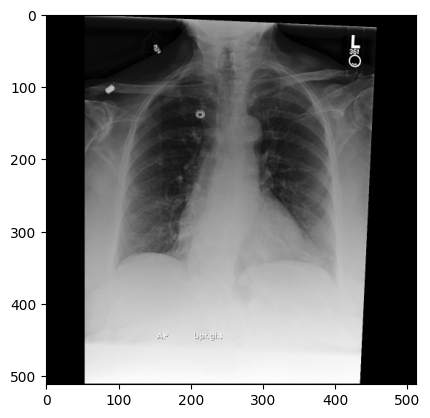

In [6]:
plt.imshow(img)
plt.show()

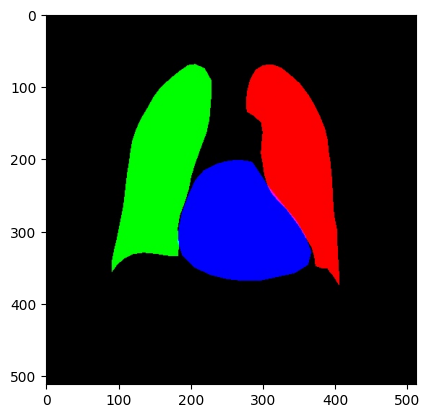

In [7]:
plt.imshow(hint)
plt.show()

In [8]:
mask = hint.copy()
mask[mask > 1e-5] = 1
mask = np.any(mask, axis=2)
inv_mask = np.invert(mask)

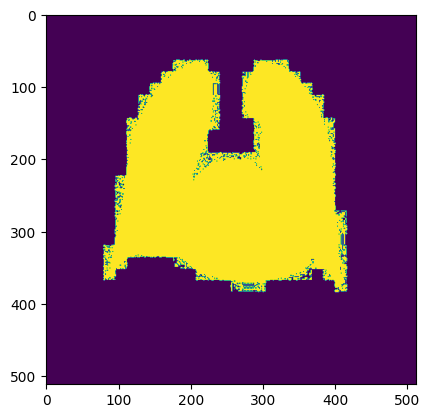

In [9]:
plt.imshow(mask)
plt.show()

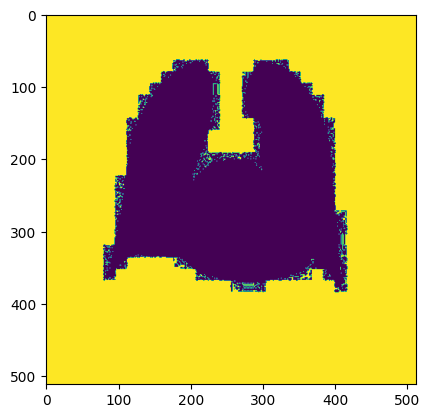

In [10]:
plt.imshow(inv_mask)
plt.show()

In [11]:
from diffusers import StableDiffusionInpaintPipeline
from diffusers import AutoPipelineForInpainting


# model_path = "roentgen"
model_path = "/data/scratch/qixuanj/cxr_finetune"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="bf16",
    torch_dtype=torch.float16,
)

pipe = pipe.to(device)

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|                                                      | 0/7 [00:00<?, ?it/s]/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████████████████████████████████████████| 7/7 [01:01<00:00,  8.73s/it]


In [12]:
pipe.enable_model_cpu_offload()

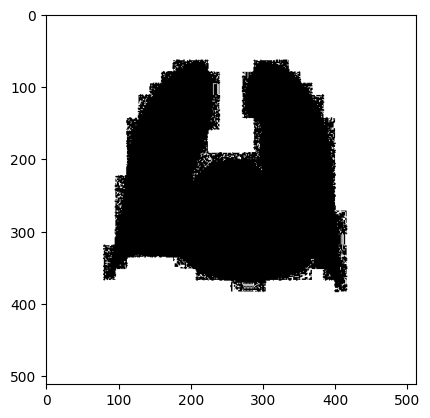

In [13]:
mask_mod = np.uint8(255 * inv_mask)
plt.figure()
plt.imshow(mask_mod, cmap="gray")

In [63]:
# mask_mod = np.repeat(mask_mod[:, :, np.newaxis], 3, axis=2)

In [14]:
img_mod = Image.fromarray((255 * img).astype(np.uint8))

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.66it/s]


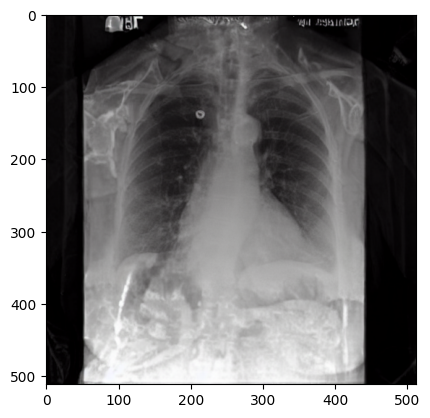

In [30]:
image = pipe(prompt= "a radiograph from dataset padchest with conditions Cardiomegaly, Pneumonia", 
         image=img_mod, 
         mask_image=Image.fromarray(mask_mod).convert("L"), 
         strength=0.8,
         guidance_scale = 5,
         num_inference_steps=20).images[0]

plt.figure()
plt.imshow(image)

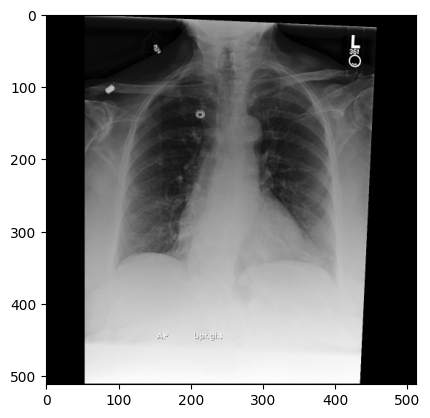

In [31]:
plt.imshow(img)

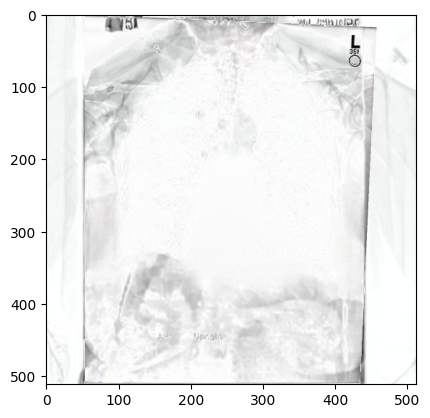

In [32]:
diff = 255 - cv2.absdiff(np.array(img_mod), np.array(image))
plt.imshow(diff)

In [33]:
img_gray = cv2.cvtColor(np.array(img_mod), cv2.COLOR_BGR2GRAY)
image_gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

In [34]:
from skimage.metrics import structural_similarity

In [35]:
(score, diff) = structural_similarity(img_gray, image_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

Image Similarity: 60.9167%


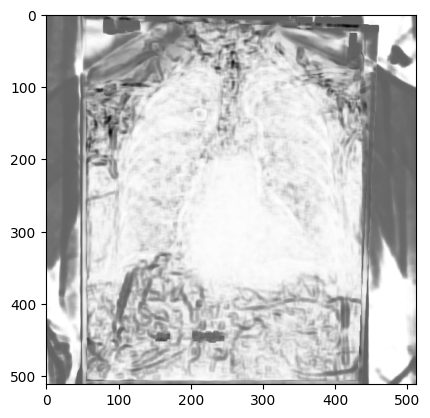

In [36]:
plt.imshow(diff, cmap='gray')
plt.show()

In [37]:
diff = (diff * 255).astype("uint8")

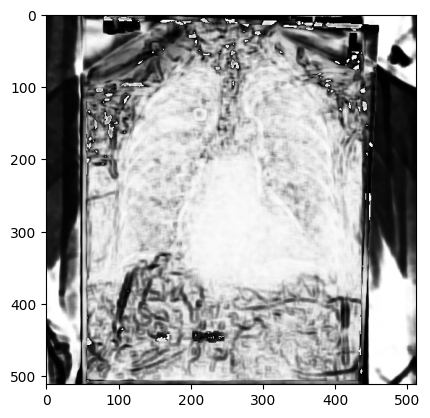

In [38]:
plt.imshow(diff, cmap='gray')
plt.show()

# Read the masks from CheXMask 

In [152]:
import torchxrayvision as xrv
from sklearn.model_selection import GroupShuffleSplit
import skimage, torch, torchvision

In [153]:
seed = 0 
pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"]

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])
gss = GroupShuffleSplit(train_size=0.8,test_size=0.2, random_state=seed)
gss_val = GroupShuffleSplit(train_size=0.875,test_size=0.125, random_state=seed)

Setting XRayResizer engine to cv2 could increase performance.


In [159]:
nih_path = "/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/OriginalResolution/ChestX-Ray8.csv"
df_mask = pd.read_csv(nih_path)

In [154]:
dataset = xrv.datasets.NIH_Dataset(imgpath="/data/healthy-ml/gobi1/data/ChestXray8/images",
                                 transform=transform, views=["PA","AP"], unique_patients=False)
# Standardization for NIH 
new_labels = pd.DataFrame(dataset.labels, columns = dataset.pathologies)
# Combine "Mass" and "Nodule" as "Lesion" class
new_labels['Lesion'] = new_labels['Mass'] + new_labels['Nodule']
new_labels['Lesion'][new_labels['Lesion'] > 1] = 1
# If all negative findings for original labels, set as no finding  
new_labels['No Finding'] = new_labels.eq(0).all(axis=1).astype(float)
dataset.pathologies = new_labels.columns.values
dataset.labels = new_labels.values
    
xrv.datasets.relabel_dataset(pathologies, dataset)
train_inds, test_inds = next(gss.split(X=range(len(dataset)), groups=dataset.csv.patientid))
train_inds, val_inds = next(gss_val.split(X=range(len(train_inds)), groups=train_inds))
split_datasets = {}
split_datasets["train"] = xrv.datasets.SubsetDataset(dataset, train_inds)
split_datasets["val"] = xrv.datasets.SubsetDataset(dataset, val_inds)
split_datasets["test"] = xrv.datasets.SubsetDataset(dataset, test_inds)

{'Nodule', 'Emphysema', 'Infiltration', 'Effusion', 'Hernia', 'Mass', 'Pleural_Thickening', 'Fibrosis'} will be dropped


In [167]:
from CheXmask_Database.DataPostprocessing.utils import get_mask_from_RLE

In [233]:
example = df_mask[df_mask['Image Index'] == split_datasets["test"].csv.iloc[0]['Image Index']]

In [234]:
height = example["Height"].iloc[0]
width = example["Width"].iloc[0]
rightLungMask_RLE = example["Right Lung"].iloc[0]
leftLungMask_RLE = example["Left Lung"].iloc[0]
heartMask_RLE = example["Heart"].iloc[0]

rightLungMask = get_mask_from_RLE(rightLungMask_RLE, height, width)
leftLungMask = get_mask_from_RLE(leftLungMask_RLE, height, width)
heartMask = get_mask_from_RLE(heartMask_RLE, height, width)

Text(0.5, 1.0, 'Heart Mask')

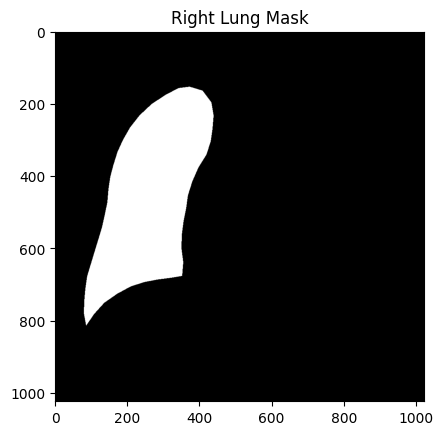

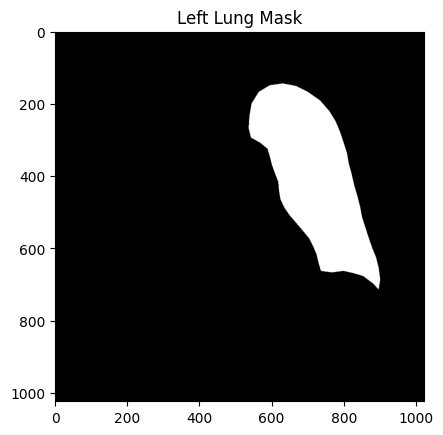

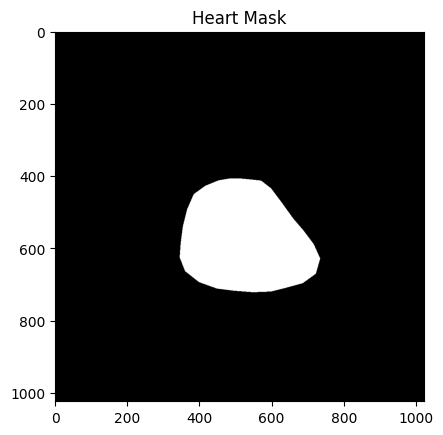

In [235]:
plt.figure()
plt.imshow(rightLungMask, cmap='gray')
plt.title("Right Lung Mask")

plt.figure()
plt.imshow(leftLungMask, cmap='gray')
plt.title("Left Lung Mask")

plt.figure()
plt.imshow(heartMask, cmap='gray')
plt.title("Heart Mask")

In [236]:
img = split_datasets["test"][0]['img'].squeeze()

In [237]:
img.shape

(224, 224)

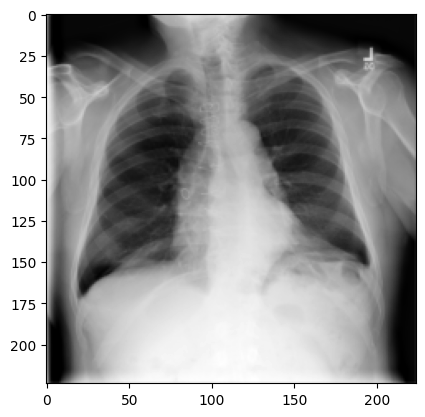

In [238]:
plt.imshow(img, cmap='gray')
plt.show()

In [239]:
img.min()

-1024.0

In [240]:
img.max()

914.17316

In [241]:
rightLungMask_resized = cv2.resize(rightLungMask, (224, 224), interpolation =cv2.INTER_NEAREST)
leftLungMask_resized = cv2.resize(leftLungMask, (224, 224), interpolation =cv2.INTER_NEAREST)
heartMask_resized = cv2.resize(heartMask, (224, 224), interpolation =cv2.INTER_NEAREST)

In [242]:
# expand into 3 dimensions
scaled = np.repeat(img[:, :, np.newaxis], 3, axis=2)
# Normalize image to between 0 and 255
scaled = (255*(scaled - np.min(scaled))/np.ptp(scaled)).astype(int) 

In [243]:
# color to fill
green = np.array([0,255,0], dtype='uint8') 
blue = np.array([0,0,255], dtype='uint8')
red = np.array([255,0,0], dtype='uint8')

# equal color where mask, else image
# this would paint your object silhouette entirely with `color`
masked_img = np.where(rightLungMask_resized[...,None], green, scaled)
masked_img = np.where(leftLungMask_resized[...,None], blue, masked_img)
masked_img = np.where(heartMask_resized[...,None], red, masked_img)

# use `addWeighted` to blend the two images
# the object will be tinted toward `color`
out = cv2.addWeighted(scaled, 0.8, masked_img, 0.2,0)

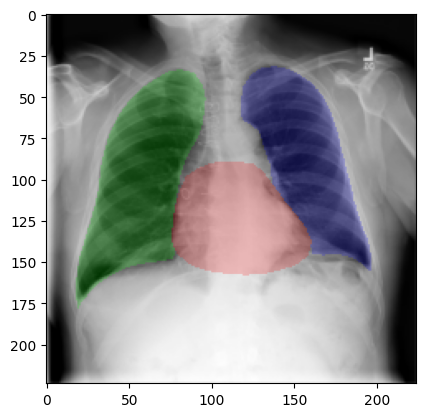

In [245]:
plt.imshow(out)
plt.show()